In [1]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

In [2]:
# Load the data set
data = pd.read_csv('data_daily.csv')
data

,# Date,Receipt_Count
0,2021-01-01,7564766
1,2021-01-02,7455524
2,2021-01-03,7095414
3,2021-01-04,7666163
4,2021-01-05,7771289
...,...,...
360,2021-12-27,10350408
361,2021-12-28,10219445
362,2021-12-29,10313337
363,2021-12-30,10310644


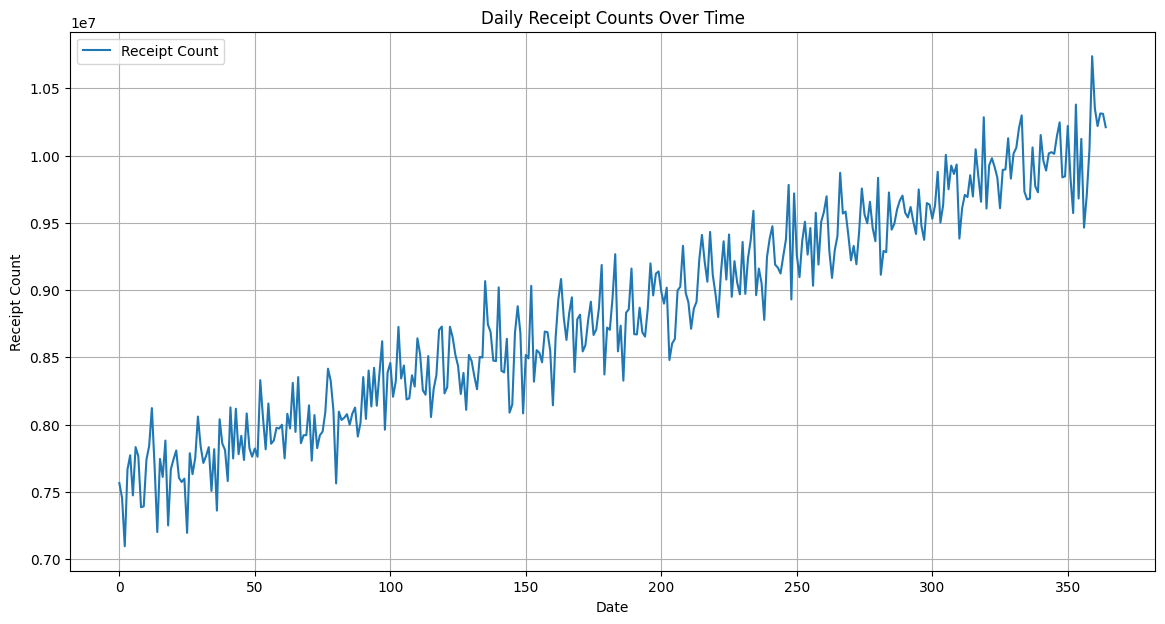

In [3]:
# Plot the data set to look at the overall trend
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Receipt_Count'], label='Receipt Count')
plt.title('Daily Receipt Counts Over Time')
plt.xlabel('Date')
plt.ylabel('Receipt Count')
plt.legend()
plt.grid(True)
plt.show()

In [4]:
# Since this is a time series forecasting problem I decided to use the Linear Regression, AMIRA, and SAMIRA models
# Both AMIRA and SAMIRA models work best when the data is stationary
# Check data set for stationarity with the Dickey-Fuller test
adf_result = adfuller(data['Receipt_Count'])
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

ADF Statistic: 0.1750441657200566
p-value: 0.9708266454651425


In [5]:
# The data set wasn't stationary so the models wouldn't be accurate
# Used differencing and logarithmic transformations to make data more stationary
data['Receipt_Count_Log'] = np.log(data['Receipt_Count'])
data['Receipt_Count_Log_Diff'] = data['Receipt_Count_Log'].diff()
data

,# Date,Receipt_Count,Receipt_Count_Log,Receipt_Count_Log_Diff
0,2021-01-01,7564766,15.839012,NaN
1,2021-01-02,7455524,15.824466,-0.014546
2,2021-01-03,7095414,15.774959,-0.049507
3,2021-01-04,7666163,15.852327,0.077368
4,2021-01-05,7771289,15.865947,0.013620
...,...,...,...,...
360,2021-12-27,10350408,16.152536,-0.036843
361,2021-12-28,10219445,16.139803,-0.012734
362,2021-12-29,10313337,16.148948,0.009146
363,2021-12-30,10310644,16.148687,-0.000261


In [6]:
# Ran ADF again and this time the data is more stationary so the models can be ran
adf_result = adfuller(data['Receipt_Count_Log_Diff'].dropna())
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

ADF Statistic: -8.681140434761929
p-value: 4.282879574750571e-14


In [7]:
# Split the data for cross-validation
tscv = TimeSeriesSplit(n_splits=10)

In [8]:
# Clean and separate the data for the linear regression model
X = np.arange(len(data)).reshape(-1, 1)
y = data['Receipt_Count'].values

In [9]:
# Fit the Linear Regression model and calculate and display MSE
lr_mse_scores = []
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    lr = LinearRegression().fit(X_train, y_train)
    lr_predictions = lr.predict(X_test)
    lr_mse_scores.append(mean_squared_error(y_test, lr_predictions))
    
print(lr_mse_scores)

[43806765562.441826, 42361262800.14972, 36772804622.75603, 71918393920.63835, 51341542284.279076, 45073594268.72881, 52331809914.37447, 34618309220.87427, 34226875515.34995, 70499360057.80138]


In [10]:
# Use the trandformed data for the ARIMA and SARIMA models
y_values = data['Receipt_Count_Log_Diff'].dropna()
y = y_values.values

X = X[1:]
print(len(X))
print(len(y))

364
364


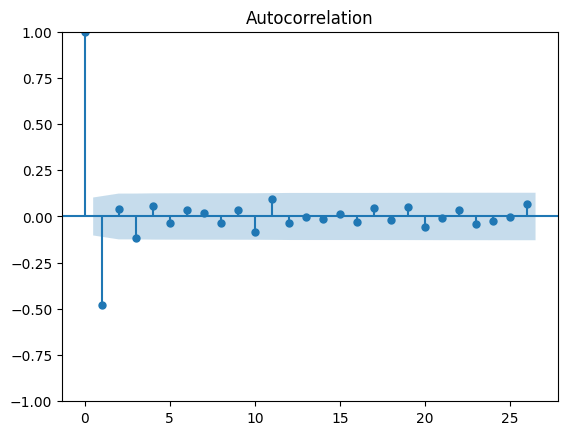

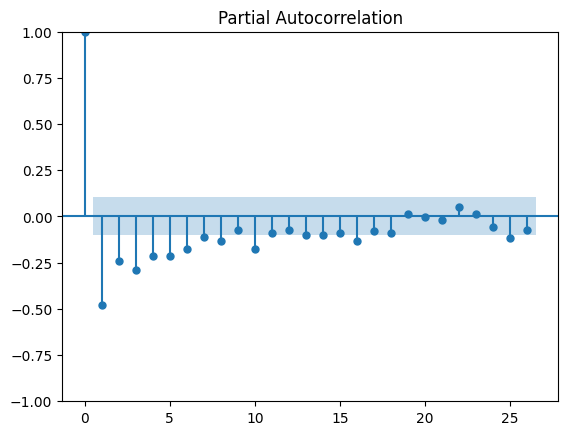

In [11]:
# Plot the Autocorrelation and Partial Autocorrelation to determine p and q values for the models
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(data['Receipt_Count_Log_Diff'].dropna())
plot_pacf(data['Receipt_Count_Log_Diff'].dropna())

plt.show()

In [22]:
# p = 6 based off the graph
# q = 1 based off the graph
# d = 1 since the differenced the data only once
p, d, q = 6, 1, 1
arima_mse_scores = []

# Fit the ARIMA model and calculate and display MSE
for train_index, test_index in tscv.split(y):
    y_train, y_test = y[train_index], y[test_index]
    model = ARIMA(y_train, order=(p, d, q))
    arima_result = model.fit()
    arima_forecast = arima_result.get_forecast(steps=len(test_index))
    arima_mean_forecast = arima_forecast.predicted_mean
    mse = mean_squared_error(y_test, arima_mean_forecast)
    arima_mse_scores.append(mse)
    
print(arima_mse_scores)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive para

[0.0016379094302555706, 0.0024326565711846027, 0.0008359319612878743, 0.0020393241922172225, 0.0013620202875082442, 0.0007704466877011403, 0.0027932064967055342, 0.0006507315958064977, 0.0007466331881314872, 0.0014593782126378458]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [32]:
# Reuse values from ARIMA model
p, d, q = 6, 1, 1
P, D, Q, S = 6, 1, 1, 12
sarima_mse_scores = []

# Fit the SARIMA model and calculate and display MSE
for train_index, test_index in tscv.split(y):
    y_train, y_test = y[train_index], y[test_index]
    sarima = SARIMAX(y_train, order=(p, d, q), seasonal_order=(P, D, Q, S)).fit(disp=0)
    sarima_predictions = sarima.get_forecast(steps=len(test_index)).predicted_mean
    sarima_mse_scores.append(mean_squared_error(y_test, sarima_predictions))
    
print(sarima_mse_scores)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:9

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[0.0069010192510368116, 0.001922552576995866, 0.001333361841597672, 0.002181437138169426, 0.0013997581765432415, 0.0011724204105975579, 0.004292058625127468, 0.0008089445487132511, 0.0007499675639327714, 0.0018121625309871759]


In [33]:
# Calculate the average MSE for three models and choose the model with the least MSE
print(f'Linear Regression MSE: {np.mean(lr_mse_scores)}')
print(f'ARIMA MSE: {np.mean(arima_mse_scores)}')
print(f'SARIMA MSE: {np.mean(sarima_mse_scores)}')

best_model = min([('Linear Regression', np.mean(lr_mse_scores)),
                  ('ARIMA', np.mean(arima_mse_scores)),
                  ('SARIMA', np.mean(sarima_mse_scores))], key=lambda x: x[1])

print(f'The best model is {best_model[0]} with an average MSE of {best_model[1]}')

Linear Regression MSE: 48295071816.739395
ARIMA MSE: 0.0014728238623436022
SARIMA MSE: 0.0022573682663701244
The best model is ARIMA with an average MSE of 0.0014728238623436022


In [112]:
# Transform the data so it can be used to make 12 month prediction with the AMIRA model
data['# Date'] = pd.to_datetime(data['# Date'])
data.set_index('# Date', inplace=True)
data.index = pd.DatetimeIndex(data.index).to_period('D')
data

,Receipt_Count,Receipt_Count_Log,Receipt_Count_Log_Diff
# Date,,,
2021-01-01,7564766,15.83901,NaN
2021-01-02,7455524,15.82447,-0.01455
2021-01-03,7095414,15.77496,-0.04951
2021-01-04,7666163,15.85233,0.07737
2021-01-05,7771289,15.86595,0.01362
...,...,...,...
2021-12-27,10350408,16.15254,-0.03684
2021-12-28,10219445,16.13980,-0.01273
2021-12-29,10313337,16.14895,0.00915


In [113]:
# Run the AMIRA model to make the 12 month prediction for 2022
model = ARIMA(data['Receipt_Count_Log_Diff'].dropna(), order=(6, 1, 1))
arima_result = model.fit()

forecast = arima_result.get_forecast(steps=365)
forecast_mean = forecast.predicted_mean

last_known_value = data['Receipt_Count_Log'].iloc[-1]
forecast_mean = last_known_value + forecast_mean.cumsum()
forecast_mean = np.exp(forecast_mean)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [115]:
# Display aggregate monthly totals for 2021 as a sanity check
# Need to see the continued increase trend in 2022 data
monthly_totals = data['Receipt_Count'].resample('M').sum()
print(monthly_totals)

# Date
2021-01    236736687
2021-02    220033460
2021-03    248608625
2021-04    250644830
2021-05    263151748
2021-06    260656840
2021-07    274776003
2021-08    283943231
2021-09    281146154
2021-10    295965185
2021-11    296085162
2021-12    309948684
Freq: M, Name: Receipt_Count, dtype: int64


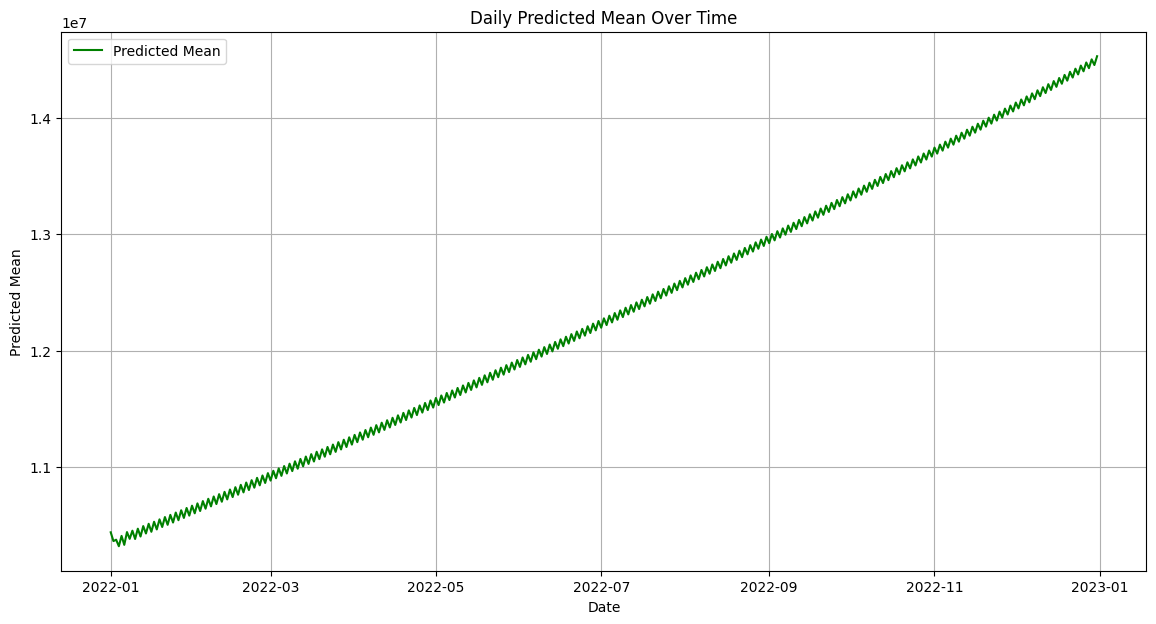

In [118]:
# Plot the predicted trend for 2022 for visualization
forecast_mean.index = forecast_mean.index.to_timestamp()

plt.figure(figsize=(14, 7))
plt.plot(forecast_mean.index, forecast_mean.values, label='Predicted Mean', color='green')
plt.title('Daily Predicted Mean Over Time')
plt.xlabel('Date')
plt.ylabel('Predicted Mean')
plt.legend()
plt.grid(True)
plt.show()

In [120]:
# Display aggregate monthly totals for 2022
monthly_totals = forecast_mean.resample('M').sum()
pd.options.display.float_format = '{:.0f}'.format

print(monthly_totals)

2022-01-31   325195036
2022-02-28   301762010
2022-03-31   343330967
2022-04-30   341829597
2022-05-31   363399455
2022-06-30   361735619
2022-07-31   384490411
2022-08-31   395780059
2022-09-30   393973023
2022-10-31   418760508
2022-11-30   416916990
2022-12-31   443213238
Freq: M, Name: predicted_mean, dtype: float64
